In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import tensorflow as tf
import sys

import onnx
import onnx_tf
import onnxruntime
import scipy

print("Tensorflow ",tf.__version__)
print("Numpy ", np.__version__)
print("Scipy ", scipy.__version__)
print("Pandas ", pd.__version__)
print("Matplotlib ", matplotlib.__version__)
print("Python ", sys.version)

print("onnx ", onnx.__version__)
print("onnx_tf", onnx_tf.__version__)
print("onnxruntime", onnxruntime.__version__)

tf.keras.utils.set_random_seed(2022)
rng = np.random.default_rng()

Tensorflow  2.9.1
Numpy  1.22.4
Scipy  1.9.0
Pandas  1.4.3
Matplotlib  3.5.2
Python  3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
onnx  1.12.0
onnx_tf 1.10.0
onnxruntime 1.11.1


# Explore ACAS-Xu Distillation

In this notebook, we demonstrate network distillation and verification using acas xu, and create figures such as the decision boundary heatmap.

In [2]:
acas_xu = onnx.load("../../data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx")
acas_xu = onnx_tf.backend.prepare(acas_xu)

2022-11-06 16:51:45.532414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train student network using Data-Free Distillation

In [3]:
## Generate synthetic dataset using a random distribution.
num_synthetic_points = 2**16

synthetic_inputs_axasxu = (rng.random((num_synthetic_points,1,1,5),dtype="float32")-0.5)
onnx_outputs = acas_xu.run(synthetic_inputs_axasxu)

synthetic_inputs = synthetic_inputs_axasxu.reshape((num_synthetic_points,5))
synthetic_outputs = onnx_outputs.linear_7_Add


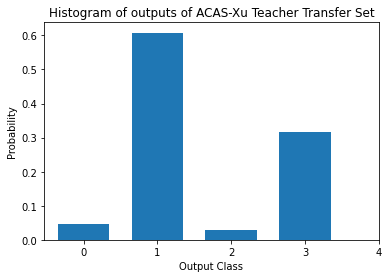

In [4]:
plt.hist(np.argmax(synthetic_outputs, axis=1), bins=[0,1,2,3,4], align="left", rwidth=0.7, density=True)
plt.xticks([0,1,2,3,4])
plt.xlabel("Output Class")
plt.ylabel("Probability")
plt.title("Histogram of outputs of ACAS-Xu Teacher Transfer Set")
plt.show()

In [5]:
## Acas XU from Reluplex paper is 6 hidden layers with 50 relu each (300 hidden units)
#Katz, G., Barrett, C., Dill, D.L., Julian, K., Kochenderfer, M.J. (2017). Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks. In: Majumdar, R., Kunčak, V. (eds) Computer Aided Verification. CAV 2017. Lecture Notes in Computer Science(), vol 10426. Springer, Cham. https://doi.org/10.1007/978-3-319-63387-9_5

hidden_layer_width=50
num_hidden_layers=4

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(5))

## Build keras model from layers using keras.Sequential
student_model = tf.keras.Sequential(layers)
student_model.summary()

# def distillation_loss(teacher_logits, student_logits):
#     temperature = 100.0
#     alpha = 1.0
#     distillation_loss = tf.keras.losses.KLDivergence()(
#         tf.nn.softmax(teacher_logits / temperature, axis=-1),
#         tf.nn.softmax(student_logits / temperature, axis=-1)
#     ) * temperature**2
#     student_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(teacher_logits, student_logits)
#     return alpha * distillation_loss + (1.0-alpha) * student_loss

student_model.compile(
    #loss=distillation_loss,
    #loss=tf.keras.losses.KLDivergence(),
    #loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    #metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.CategoricalCrossentropy(from_logits=False), tf.keras.metrics.CategoricalAccuracy()],
    #optimizer=tf.keras.optimizers.SGD()
    optimizer=tf.keras.optimizers.Adam(0.001)
)

student_model.fit(
    x=synthetic_inputs,
    #y=synthetic_outputs,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    y=synthetic_outputs.argmax(axis=1).flatten(),
    epochs=1000,
    batch_size=2**10,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    ]
    )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                300       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 5)                 255       
                                                                 
Total params: 8,205
Trainable params: 8,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
64/64 - 1s - loss: 1.1681 - sparse_catego

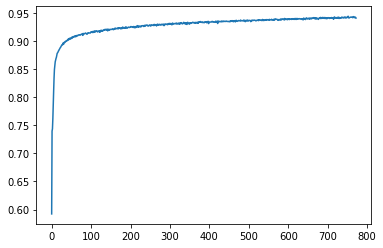

In [6]:
plt.plot(student_model.history.history["sparse_categorical_accuracy"])

7813/7813 [==============================] - 6s 714us/step


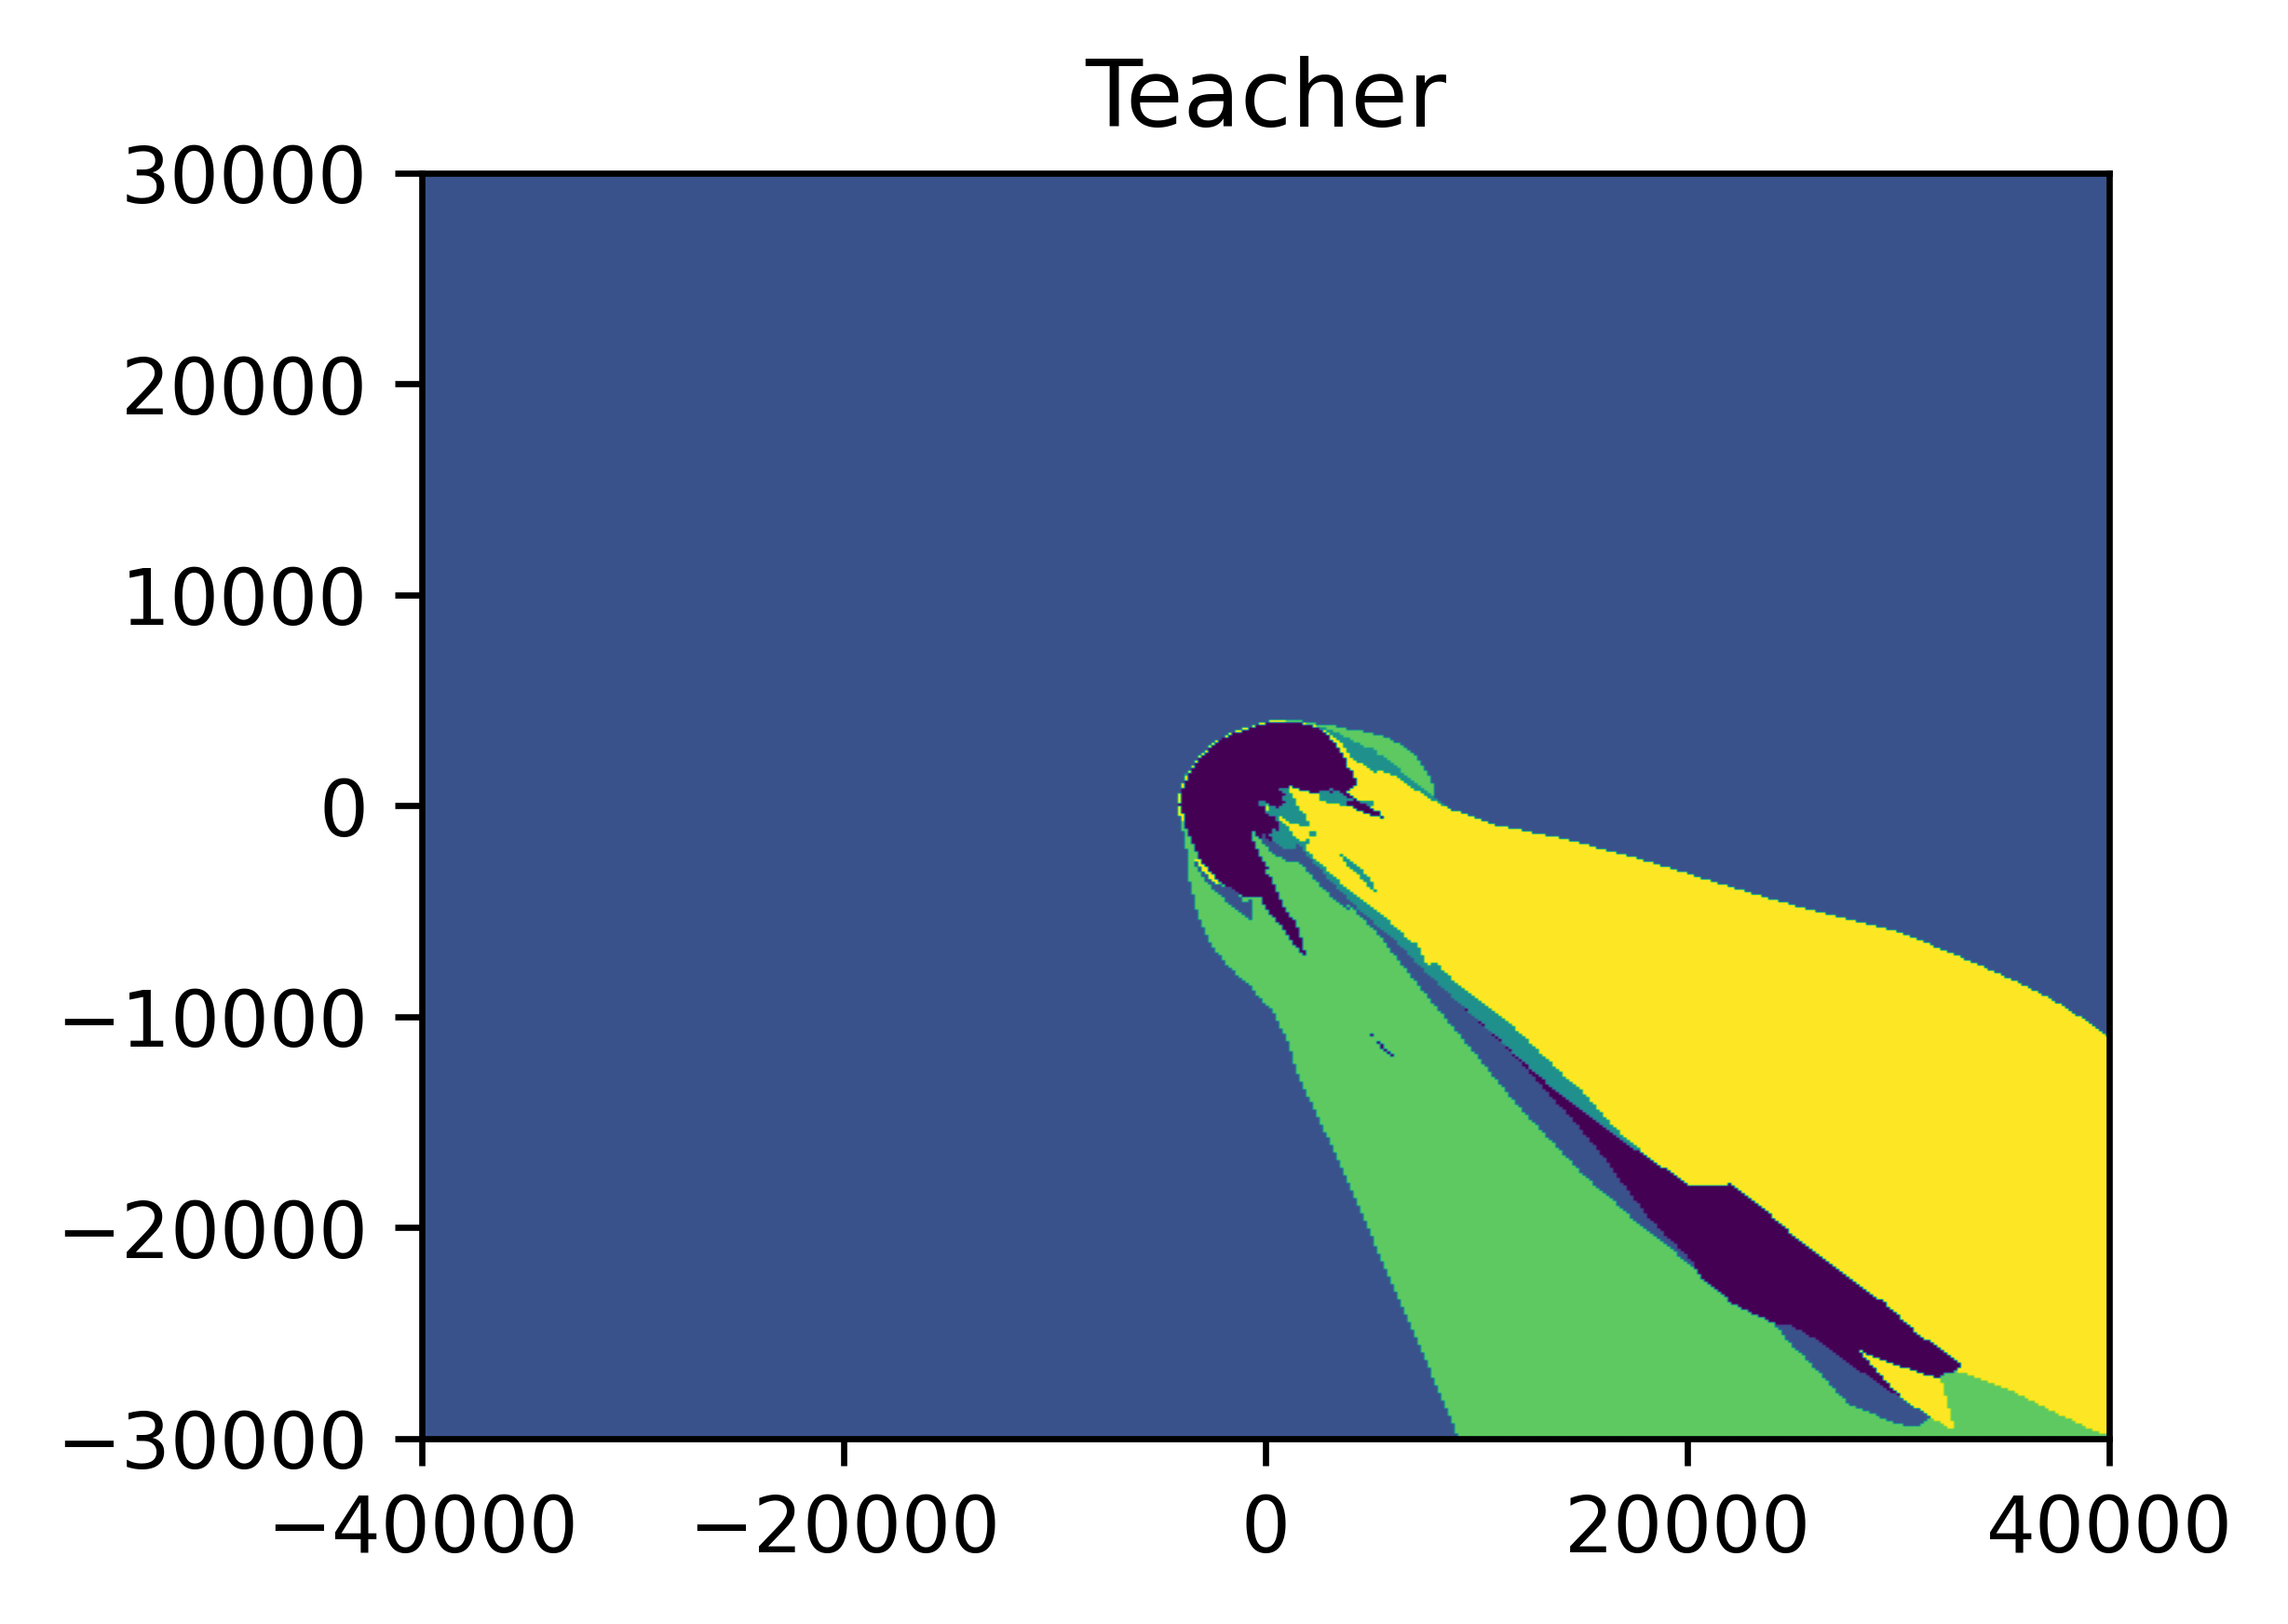

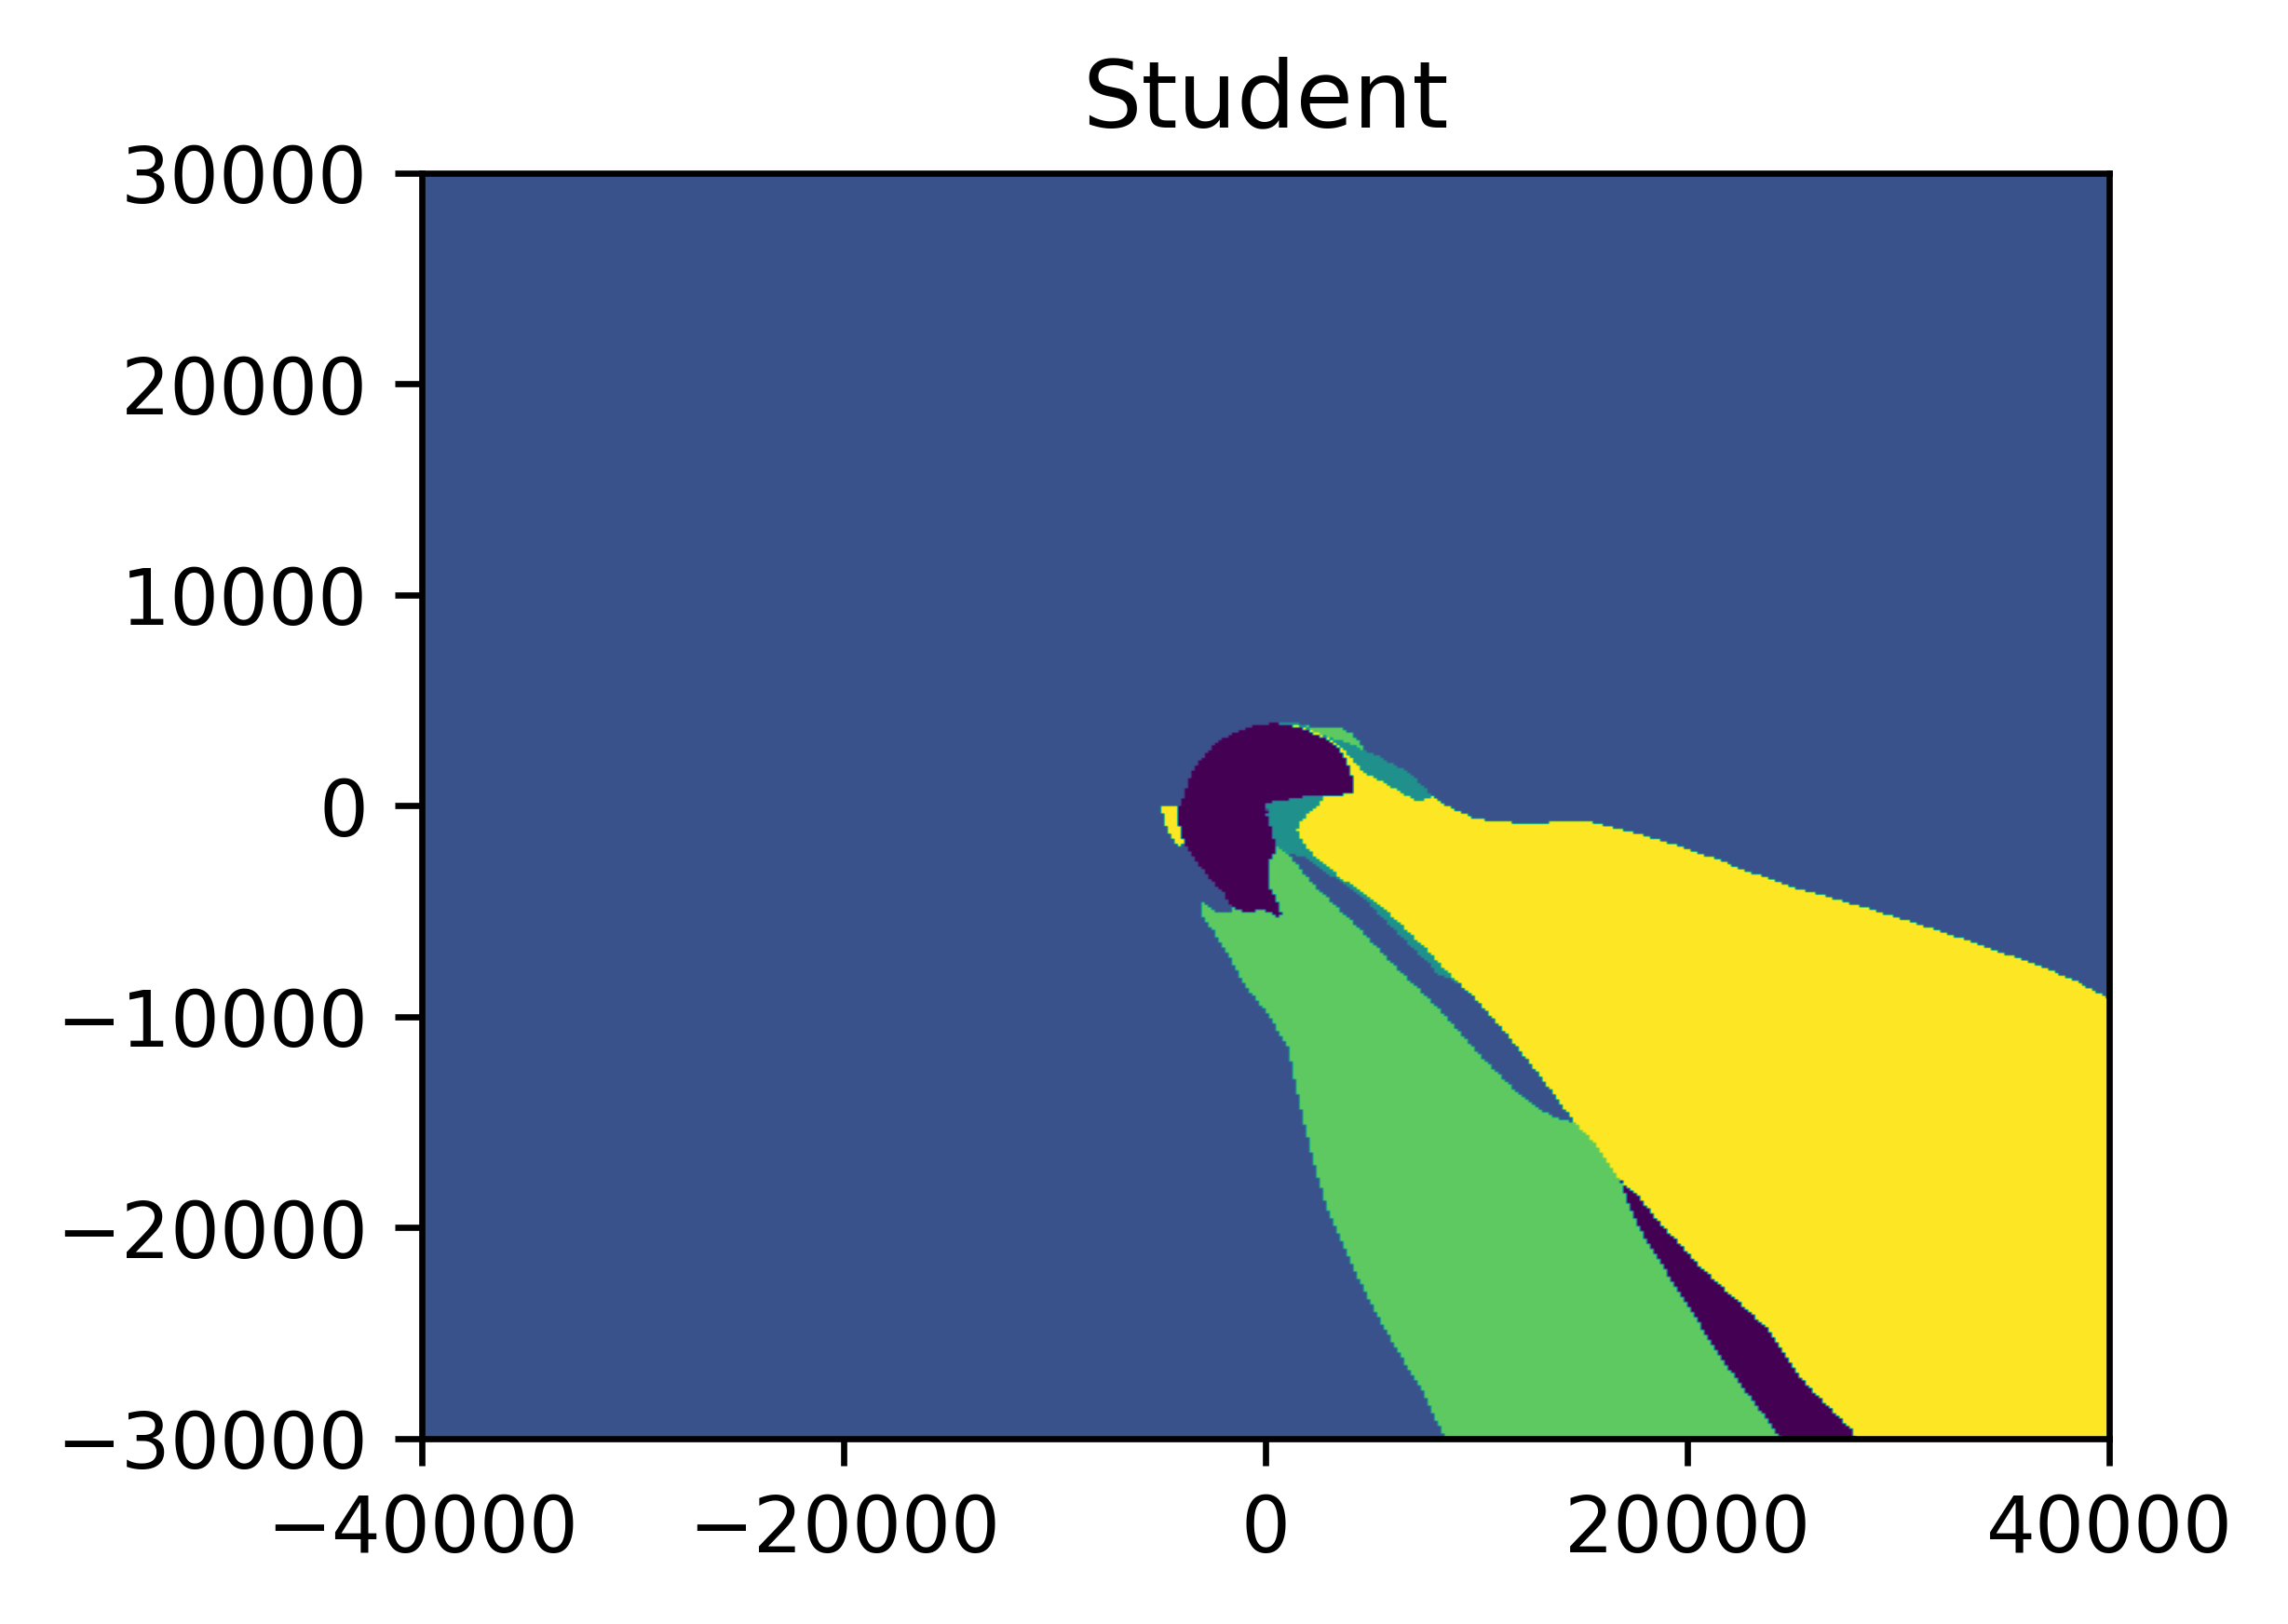

In [7]:
# Input Scaling

nx, ny = (500, 500)

x = np.linspace(-40000,40000, nx)
y = np.linspace(-30000,30000, ny)
xx,yy = np.meshgrid(x,y)

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

tt,rr = cart2pol(xx,yy)

inputs_here = [rr.flatten(), # Distance between ownship and intruder
               tt.flatten(), # Angle between ownship and intruder
               -np.pi/2, # Angle of intruder relative to angle of ownship
               600, # Velocity of ownship
               600] # Velocity of intruder

## From VNNCOMP repository
means_for_scaling = [19791.091, 0.0, 0.0, 650.0, 600.0, 7.5188840201005975]
range_for_scaling = [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0]

coords = np.zeros(shape=(nx*ny,1,1,5),dtype="float32")
for i in range(5):
    coords[:,0,0,i] = (inputs_here[i] - means_for_scaling[i])/range_for_scaling[i]


teacher_image = acas_xu.run(coords).linear_7_Add.argmax(axis=1)
student_image = student_model.predict(coords.reshape(nx*ny,5)).argmax(axis=1)


extent = -40000, 40000, -30000, 30000
plt.figure(figsize=(4,3),dpi=600)
plt.imshow(teacher_image.reshape(nx,ny), extent=extent)
plt.title("Teacher")
plt.show()

plt.figure(figsize=(4,3),dpi=600)
plt.imshow(student_image.reshape(nx,ny), extent=extent)
plt.title("Student")
plt.show()

## Verify student and teacher networks

Use the 10 properties provided in VNNComp to check if the student network satisfies the safety properties. Produce the following:

- Timing information
- Counterexamples
- Failiure modes of nnenum
- List of verified networks

## NNenum

In [8]:
tf.saved_model.save(student_model, "../../output_data/acasxu_distillation/student_model")

INFO:tensorflow:Assets written to: ../../output_data/acasxu_distillation/student_model/assets


In [9]:
!python -m tf2onnx.convert --saved-model ../../output_data/acasxu_distillation/student_model --output ../../output_data/acasxu_distillation/student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-11-06 16:56:44,149 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-11-06 16:56:44,503 - INFO - Signatures found in model: [serving_default].
2022-11-06 16:56:44,503 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-11-06 16:56:44,503 - INFO - Output names: ['dense_4']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-11-06 16:56:44,562 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.comp

In [12]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image bash -c "python3 -m nnenum.nnenum /distill/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /distill/data/acasxu/prop_1.vnnlib > /distill/output_data/acasxu_distillation/verify_teacher.stdout"

In [ ]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image bash -c "python3 -m nnenum.nnenum /distill/output_data/acasxu_distillation/student_model.onnx /distill/data/acasxu/prop_1.vnnlib > /distill/output_data/acasxu_distillation/verify_student.stdout"

## All 10 properties with timing

In [14]:
import subprocess
import re

In [17]:
for prop in range(1,10+1):
    print(f"Property {prop}")

    cmd = f"docker run -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image python3 -m nnenum.nnenum /distill/output_data/acasxu_distillation/student_model.onnx /distill/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    try:
        runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
        result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
        print(f"\tStudent:\tTime={runtime_re}\tOutput={result_re}")
    except Exception as e:
        print("Exception")

    cmd = f"docker run -v /Users/jperrsau/cu-src/thesis/src/distill:/distill nnenum_image python3 -m nnenum.nnenum /distill/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /distill/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    try:
        runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
        result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
        print(f"\tTeacher:\tTime={runtime_re}\tOutput={result_re}")
    except Exception as e:
        print("Exception")


    

Property 1
	Student:	Time=0.7	Output=network is SAFE
	Teacher:	Time=0.6	Output=network is SAFE
Property 2
	Student:	Time=0.6	Output=network is SAFE
	Teacher:	Time=1.2	Output=network is SAFE
Property 3
Exception
	Teacher:	Time=1.8	Output=network is SAFE
Property 4
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.7	Output=network is SAFE
Property 5
	Student:	Time=0.2	Output=network is SAFE
	Teacher:	Time=3.5	Output=network is SAFE
Property 6
	Student:	Time=0.5	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=7.6	Output=network is SAFE
Running in parallel with 
Property 7
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
Property 8
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in r